In [4]:
from scipy.io import wavfile
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import os
import seaborn as sns
import random
import sys
import scipy.spatial.distance as scipydt
from numpy.linalg import inv
from tqdm import tqdm

img = plt.imread('im0.ppm')
left_img = img

img2 = plt.imread('im8.ppm')
right_img = img2

rows = left_img.shape[0]
cols = left_img.shape[1]

d_mat = np.zeros(shape=(381,390))
for r in range(rows):
    a = right_img[r,:]
    for pic in range(a.shape[0]-40):
        ind = np.argmin(scipydt.cdist([a[pic]], left_img[r, pic:pic+40], 'euclidean')[0])
        d_mat[r][pic] = ind

print(d_mat)

[[ 2.  7.  0. ...  1. 12.  7.]
 [ 9.  4.  3. ... 25.  5. 10.]
 [ 3.  8.  7. ... 30. 29. 10.]
 ...
 [16. 27. 13. ... 37. 39. 26.]
 [31. 35. 18. ... 33. 31. 33.]
 [26. 25. 24. ... 27. 32. 33.]]


In [5]:
len_vec = d_mat.shape[0] * d_mat.shape[1]
d_vec = [int(i) for i in d_mat.reshape(len_vec,)]
uniq = np.unique(d_vec)
cnt = np.bincount(d_vec)
print(cnt)

[ 3393  3317  3574  3791  4071  4772  5920 10347 14839  9665  6336  4814
  4168  3686  3811  4443  3495  2849  2692  2663  2613  2638  3090  3381
  3557  3568  2762  2279  2087  2072  2058  2278  2454  2218  1715  1608
  1515  1303  1328  1420]


148590


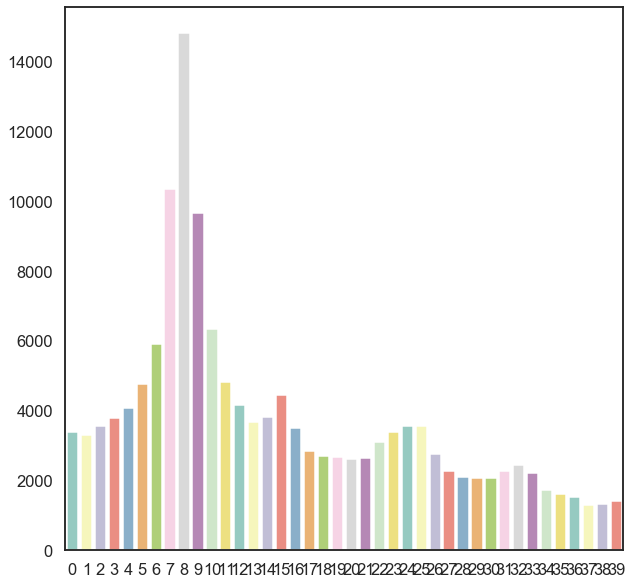

In [7]:
sns.set(style="white", context="talk")
fig,ax1 = plt.subplots(figsize=(10, 10), sharex=True)
sns.barplot(uniq, cnt, palette="Set3", ax=ax1)
plt.savefig('Q2-Histogram.png')

# Implement GMM .....
k=4
disp_vector = np.array(d_vec)
# I have used both random valuess for means and standard deviations
# But I have got better reults from initializing means from reading the histogram ...
# Initializing with random values gave similar to the results to the below values, just that these results
# were a bit better .. so used these values for means and standard deviations ....
means = np.array([ 3,27,9,26])
std_dev = np.array([ 15.16709152 ,  8.70829307 , 10.75440234 , 19.04932786])
# means = disp_vector[np.random.randint(0, len_vec - 1, size=k)]
# std_dev = np.random.uniform(5,20,k)

# Here we duplicate data to total number of clusters for finding mahalanobis distance for each cluster ....
cluster_data = np.outer(disp_vector, np.ones(k))

def maha(data_mat, mean_vec, std_dev_vec):
    num = (data_mat - mean_vec) * (data_mat - mean_vec)
    den = 2 * std_dev_vec
    maha = np.divide(num,den)
    return num


cluster_data = np.outer(disp_vector, np.ones(k))

100%|██████████| 10/10 [01:26<00:00,  8.66s/it]


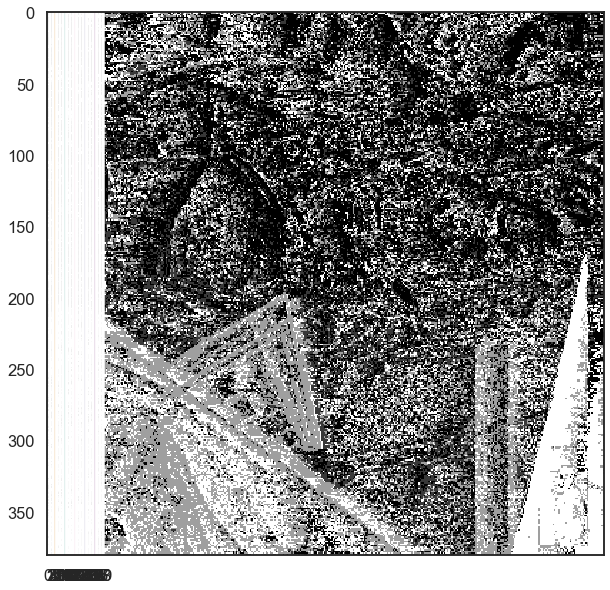

In [3]:
for i in range(100):
    c_means = means
    c_std_dev = std_dev
    maha_dist = maha(cluster_data, c_means, c_std_dev)

    x = np.exp(-1 * maha_dist)
    y = np.sqrt(2 * 3.14 * c_std_dev)

    prob_mat = (x / y)
    prob_mat_sum = np.sum(prob_mat, axis=1)
    prob_mat_norm = np.divide(prob_mat.T, prob_mat_sum.T).T

    means = np.divide(np.sum(prob_mat_norm * cluster_data, axis=0), np.sum(prob_mat_norm, axis=0))


    std_dev = np.divide(np.sum(np.square(cluster_data - prob_mat_norm) * prob_mat_norm, axis=0),
                        np.sum(prob_mat_norm, axis=0))

    prior_prob = np.sum(prob_mat_norm, axis=0) / len_vec

    if np.array_equal(np.round(c_means, 3), np.round(means, 3)) and np.array_equal(np.round(c_std_dev, 3),
                                                                                   np.round(std_dev, 3)):
        break



std_dev = std_dev / np.sum(std_dev)

assigned_mean = []
for i in range(len_vec):
    assigned_mean.append(means[np.argmax(prob_mat_norm[i,:])])
assigned_mean = np.array(assigned_mean)
assigned_mean = assigned_mean.reshape((d_mat.shape[0], d_mat.shape[1]))

assigned_std = []
for i in range(len_vec):
    assigned_std.append(std_dev[np.argmax(prob_mat_norm[i,:])])
assigned_std = np.array(assigned_std)
assigned_std = assigned_std.reshape((d_mat.shape[0], d_mat.shape[1]))

assigned_class = []
for i in range(len_vec):
    assigned_class.append(np.argmax(prob_mat_norm[i,:]))
assigned_class = np.array(assigned_class)
assigned_class = assigned_class.reshape((d_mat.shape[0], d_mat.shape[1]))


def neighbors(data,x, y):
    if x==0 and y==0:
        return np.array([data[x, y+1],data[x+1, y+1],data[x+1, y]])
    if x==380 and y==0:
        return np.array([data[x-1, y],data[x-1, y+1],data[x, y+1]])
    if x==0 and y==389:
        return np.array([data[x, y-1],data[x+1, y-1],data[x+1, y]])
    if x==380 and y==389:
        return np.array([data[x-1, y],data[x-1, y-1],data[x, y-1]])
    if x == 0:
        return np.array([data[x, y+1],data[x, y-1],data[x+1, y-1],data[x+1, y],data[x+1, y+1]])
    if x == 380:
        return np.array([data[x, y+1],data[x, y-1],data[x-1, y-1],data[x-1, y],data[x-1, y+1]])
    if y == 0:
        return np.array([data[x-1, y],data[x+1, y],data[x-1, y+1],data[x, y+1],data[x+1, y+1]])
    if y == 389:
        return np.array([data[x-1, y],data[x+1, y],data[x-1, y-1],data[x, y-1],data[x+1, y-1]])
    else:
        return np.array([data[x-1, y-1],data[x-1, y],data[x-1, y+1],data[x, y-1],data[x, y+1],data[x+1, y-1],data[x+1, y],data[x+1, y+1]])

def gaussian(x, mu, sig):
    g = (1 / np.sqrt(2 * 3.14 * sig ** 2)) * (np.exp((-0.5 * (x - mu) ** 2) / sig ** 2))
    return g

a = 1
Prob_mat = prob_mat_norm
class_list = []
for rep in tqdm(range(10)):
    new_class = []
    for i in range(0, d_mat.shape[0]):

        for j in range(0, d_mat.shape[1]):
            index = i * d_mat.shape[1] + j

            Nei_mean = neighbors(assigned_mean, i, j)

            Nei_class = neighbors(assigned_class, i, j)

            Nei_std = neighbors(assigned_std, i, j)

            z = list(np.equal(assigned_class[i, j], Nei_class))

            f_c = np.array([0 if x == True else a for x in z])

            P_c = np.exp(np.negative(np.square(f_c)))

            P_c_nei = np.prod(P_c)

            # Add the Gaussian Function here ....... for P_x_c
            x = cluster_data[index, :]
            P_x_c = gaussian(x, means, std_dev)

            P_c_x = P_x_c * P_c_nei

            P_c_x_sum = np.sum(P_c_x)
            P_c_x = P_c_x / P_c_x_sum

            nc = np.argmax(P_c_x)
            #             assigned_class[i,j] = nc
            new_class.append(nc)
    class_list.append(new_class)
    new_class = np.array(new_class)
    new_class = new_class.reshape((381, 390))
    assigned_class = new_class

matching = [[s for s in class_list[0] if s==0],[s for s in class_list[0] if s==1],[s for s in class_list[0] if s==2],[s for s in class_list[0] if s==3]]
matching = [[s for s in class_list[1] if s==0],[s for s in class_list[1] if s==1],[s for s in class_list[1] if s==2],[s for s in class_list[1] if s==3]]
matching = [[s for s in class_list[2] if s==0],[s for s in class_list[2] if s==1],[s for s in class_list[2] if s==2],[s for s in class_list[2] if s==3]]
matching = [[s for s in class_list[3] if s==0],[s for s in class_list[3] if s==1],[s for s in class_list[3] if s==2],[s for s in class_list[3] if s==3]]

new_mean = np.zeros((381,390))
for i in range(0,d_mat.shape[0]):
    for j in range(0,d_mat.shape[1]):
        new_mean[i,j] = means[assigned_class[i,j]]

plt.imshow(new_mean,cmap='gray')
plt.savefig('Gibbs-Result.png')
plt.show()